In [2]:
#pip install folium

In [3]:
import pandas as pd
import numpy as np
import requests
import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [4]:
link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
geo_coor_link = 'http://cocl.us/Geospatial_data'

result = requests.get(link)
soup = BeautifulSoup(result.text, 'html.parser')

Toronto_table=soup.find('table',{'class':"wikitable"})
toronto = pd.read_html(str(Toronto_table))
toronto = pd.DataFrame(toronto[0])
toronto = toronto[toronto.Borough != 'Not assigned'].reset_index(drop=True)

geo_coor_tor = pd.read_csv(geo_coor_link)
toronto = toronto.join(geo_coor_tor.set_index('Postal Code'), on = 'Postal Code')

print(toronto.shape)
toronto.head()

(103, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [5]:
print(toronto.shape)
toronto.head()

(103, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [6]:
old_toronto = toronto[toronto['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
old_toronto = old_toronto.drop('Borough', 1)

print(old_toronto.shape)
old_toronto.head()

(19, 4)


,Postal Code,Neighbourhood,Latitude,Longitude
0,M5A,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,St. James Town,43.651494,-79.375418
4,M5E,Berczy Park,43.644771,-79.373306


In [7]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 
new_york = pd.DataFrame(columns=column_names)

for data in newyork_data['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    new_york = new_york.append({'Borough': borough,
                                          'Neighbourhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

print(new_york.shape)
new_york.head()

(306, 4)


,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
manhattan = new_york[new_york['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan = manhattan.drop('Borough', 1)

print(manhattan.shape)
manhattan.head()

(40, 3)


,Neighbourhood,Latitude,Longitude
0,Marble Hill,40.876551,-73.910660
1,Chinatown,40.715618,-73.994279
2,Washington Heights,40.851903,-73.936900
3,Inwood,40.867684,-73.921210
4,Hamilton Heights,40.823604,-73.949688


In [9]:
address1 = 'Old Toronto'

geolocator = Nominatim(user_agent="ot_explorer")
location = geolocator.geocode(address1)
latitude1 = location.latitude
longitude1 = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address1, latitude1, longitude1))

The geograpical coordinate of Old Toronto are 43.6534817, -79.3839347.


In [10]:
address2 = 'Manhattan'

geolocator = Nominatim(user_agent="man_explorer")
location = geolocator.geocode(address2)
latitude2 = location.latitude
longitude2 = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address2, latitude2, longitude2))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [11]:
manhattan_population = 1.63 * 10 ** 6
manhattan_land_area_km = 59.1
old_toronto_population = 8 * 10 ** 5
old_toronto_land_area_km = 97.15
print('Comparing population and land area of both boroughs: population ratio {} and land ratio {}'.format(
      old_toronto_population/manhattan_population, old_toronto_land_area_km/manhattan_land_area_km))
print('Calculating the population density of them: Manhattan {} and Old Toronto {}'.format(
      manhattan_population/manhattan_land_area_km, old_toronto_population/old_toronto_land_area_km))

Comparing population and land area of both boroughs: population ratio 0.49079754601226994 and land ratio 1.643824027072758
Calculating the population density of them: Manhattan 27580.37225042301 and Old Toronto 8234.688625836336


In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], 
            v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [13]:
old_toronto_venues = getNearbyVenues(
    names = old_toronto['Neighbourhood'], latitudes = old_toronto['Latitude'], longitudes = old_toronto['Longitude'])

print(old_toronto_venues.shape)
old_toronto_venues.head()

(1221, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [14]:
old_toronto_coffee_shops = old_toronto_venues[old_toronto_venues['Venue Category'].str.contains('Coffee')]
old_toronto_restaurants = old_toronto_venues[old_toronto_venues['Venue Category'].str.contains('Restaurant')]
old_toronto_bars = old_toronto_venues[old_toronto_venues['Venue Category'].str.contains('Bar')]

print('Old Toronto has {} coffee places, {} restaurants and {} bars'.format(
      old_toronto_coffee_shops.count()[0], old_toronto_restaurants.count()[0], old_toronto_bars.count()[0]))

Old Toronto has 126 coffee places, 292 restaurants and 74 bars


In [15]:
manhattan_venues = getNearbyVenues(
    names = manhattan['Neighbourhood'], latitudes = manhattan['Latitude'], longitudes = manhattan['Longitude'])

print(manhattan_venues.shape)
manhattan_venues.head()

(3235, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [16]:
manhattan_coffee_shops = manhattan_venues[manhattan_venues['Venue Category'].str.contains('Coffee')]
manhattan_restaurants = manhattan_venues[manhattan_venues['Venue Category'].str.contains('Restaurant')]
manhattan_bars = manhattan_venues[manhattan_venues['Venue Category'].str.contains('Bar')]

print('Manhattan has {} coffee places, {} restaurants and {} bars'.format(
      manhattan_coffee_shops.count()[0], manhattan_restaurants.count()[0], manhattan_bars.count()[0]))

Manhattan has 152 coffee places, 893 restaurants and 243 bars


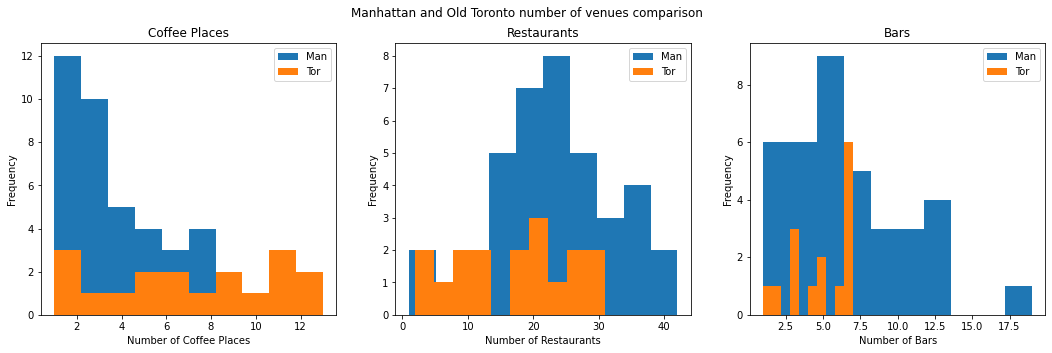

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
fig.suptitle('Manhattan and Old Toronto number of venues comparison')

ax1 = manhattan_coffee_shops.groupby(['Neighborhood'])['Venue Category'].count().plot(ax = ax1, kind = 'hist', label = 'Man')
old_toronto_coffee_shops.groupby(['Neighborhood'])['Venue Category'].count().plot(ax = ax1, kind = 'hist', label = 'Tor')
ax1.set_title('Coffee Places')
ax1.set_xlabel('Number of Coffee Places')
ax1.legend(loc = 'upper right')

ax2 = manhattan_restaurants.groupby(['Neighborhood'])['Venue Category'].count().plot(ax = ax2, kind = 'hist', label = 'Man')
old_toronto_restaurants.groupby(['Neighborhood'])['Venue Category'].count().plot(ax = ax2, kind = 'hist', label = 'Tor')
ax2.set_title('Restaurants')
ax2.set_xlabel('Number of Restaurants')
ax2.legend(loc = 'upper right')

ax3 = manhattan_bars.groupby(['Neighborhood'])['Venue Category'].count().plot(ax = ax3, kind = 'hist', label = 'Man')
old_toronto_bars.groupby(['Neighborhood'])['Venue Category'].count().plot(ax = ax3, kind = 'hist', label = 'Tor')
ax3.set_title('Bars')
ax3.set_xlabel('Number of Bars')
ax3.legend(loc = 'upper right')

plt.show()

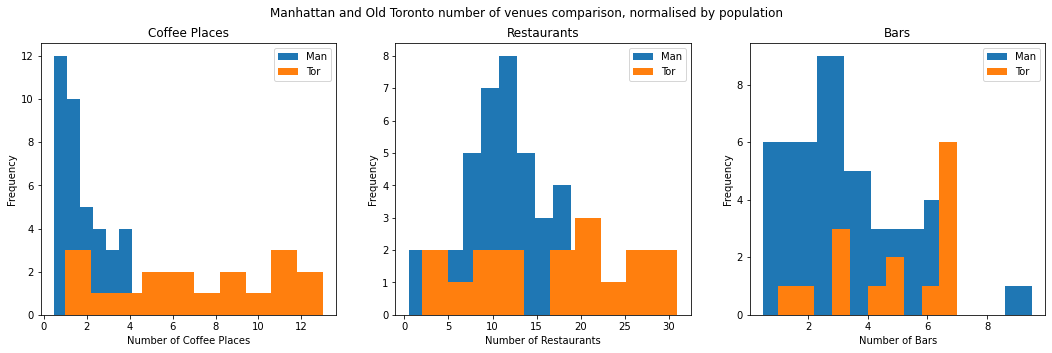

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
fig.suptitle('Manhattan and Old Toronto number of venues comparison, normalised by population')

ax1 = (manhattan_coffee_shops.groupby(['Neighborhood'])['Venue Category'].count()/2).plot(ax = ax1, kind = 'hist', label = 'Man')
old_toronto_coffee_shops.groupby(['Neighborhood'])['Venue Category'].count().plot(ax = ax1, kind = 'hist', label = 'Tor')
ax1.set_title('Coffee Places')
ax1.set_xlabel('Number of Coffee Places')
ax1.legend(loc = 'upper right')

ax2 = (manhattan_restaurants.groupby(['Neighborhood'])['Venue Category'].count()/2).plot(ax = ax2, kind = 'hist', label = 'Man')
old_toronto_restaurants.groupby(['Neighborhood'])['Venue Category'].count().plot(ax = ax2, kind = 'hist', label = 'Tor')
ax2.set_title('Restaurants')
ax2.set_xlabel('Number of Restaurants')
ax2.legend(loc = 'upper right')

ax3 = (manhattan_bars.groupby(['Neighborhood'])['Venue Category'].count()/2).plot(ax = ax3, kind = 'hist', label = 'Man')
old_toronto_bars.groupby(['Neighborhood'])['Venue Category'].count().plot(ax = ax3, kind = 'hist', label = 'Tor')
ax3.set_title('Bars')
ax3.set_xlabel('Number of Bars')
ax3.legend(loc = 'upper right')

plt.show()

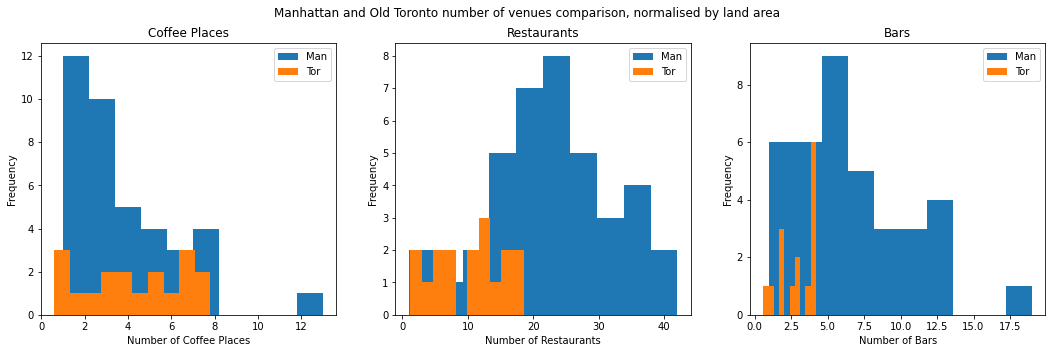

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
fig.suptitle('Manhattan and Old Toronto number of venues comparison, normalised by land area')

ax1 = manhattan_coffee_shops.groupby(['Neighborhood'])['Venue Category'].count().plot(ax = ax1, kind = 'hist', label = 'Man')
(old_toronto_coffee_shops.groupby(['Neighborhood'])['Venue Category'].count()*0.6).plot(ax = ax1, kind = 'hist', label = 'Tor')
ax1.set_title('Coffee Places')
ax1.set_xlabel('Number of Coffee Places')
ax1.legend(loc = 'upper right')

ax2 = manhattan_restaurants.groupby(['Neighborhood'])['Venue Category'].count().plot(ax = ax2, kind = 'hist', label = 'Man')
(old_toronto_restaurants.groupby(['Neighborhood'])['Venue Category'].count()*0.6).plot(ax = ax2, kind = 'hist', label = 'Tor')
ax2.set_title('Restaurants')
ax2.set_xlabel('Number of Restaurants')
ax2.legend(loc = 'upper right')

ax3 = manhattan_bars.groupby(['Neighborhood'])['Venue Category'].count().plot(ax = ax3, kind = 'hist', label = 'Man')
(old_toronto_bars.groupby(['Neighborhood'])['Venue Category'].count()*0.6).plot(ax = ax3, kind = 'hist', label = 'Tor')
ax3.set_title('Bars')
ax3.set_xlabel('Number of Bars')
ax3.legend(loc = 'upper right')

plt.show()

In [20]:
old_toronto_map = folium.Map(location=[latitude1, longitude1], zoom_start=12)

for lat, lng, label in zip(old_toronto_coffee_shops['Venue Latitude'], old_toronto_coffee_shops['Venue Longitude'], old_toronto_coffee_shops['Venue Category']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(old_toronto_map)

old_toronto_map

In [21]:
manhattan_map = folium.Map(location=[latitude2, longitude2], zoom_start=12)

for lat, lng, label in zip(manhattan_coffee_shops['Venue Latitude'], manhattan_coffee_shops['Venue Longitude'], manhattan_coffee_shops['Venue Category']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(manhattan_map)

manhattan_map